In [1]:
import numpy as np
import random
import deeptrack as dt
import deeplay as dl
import torch
import skimage
from matplotlib import pyplot as plt

(70, 16, 572, 572)


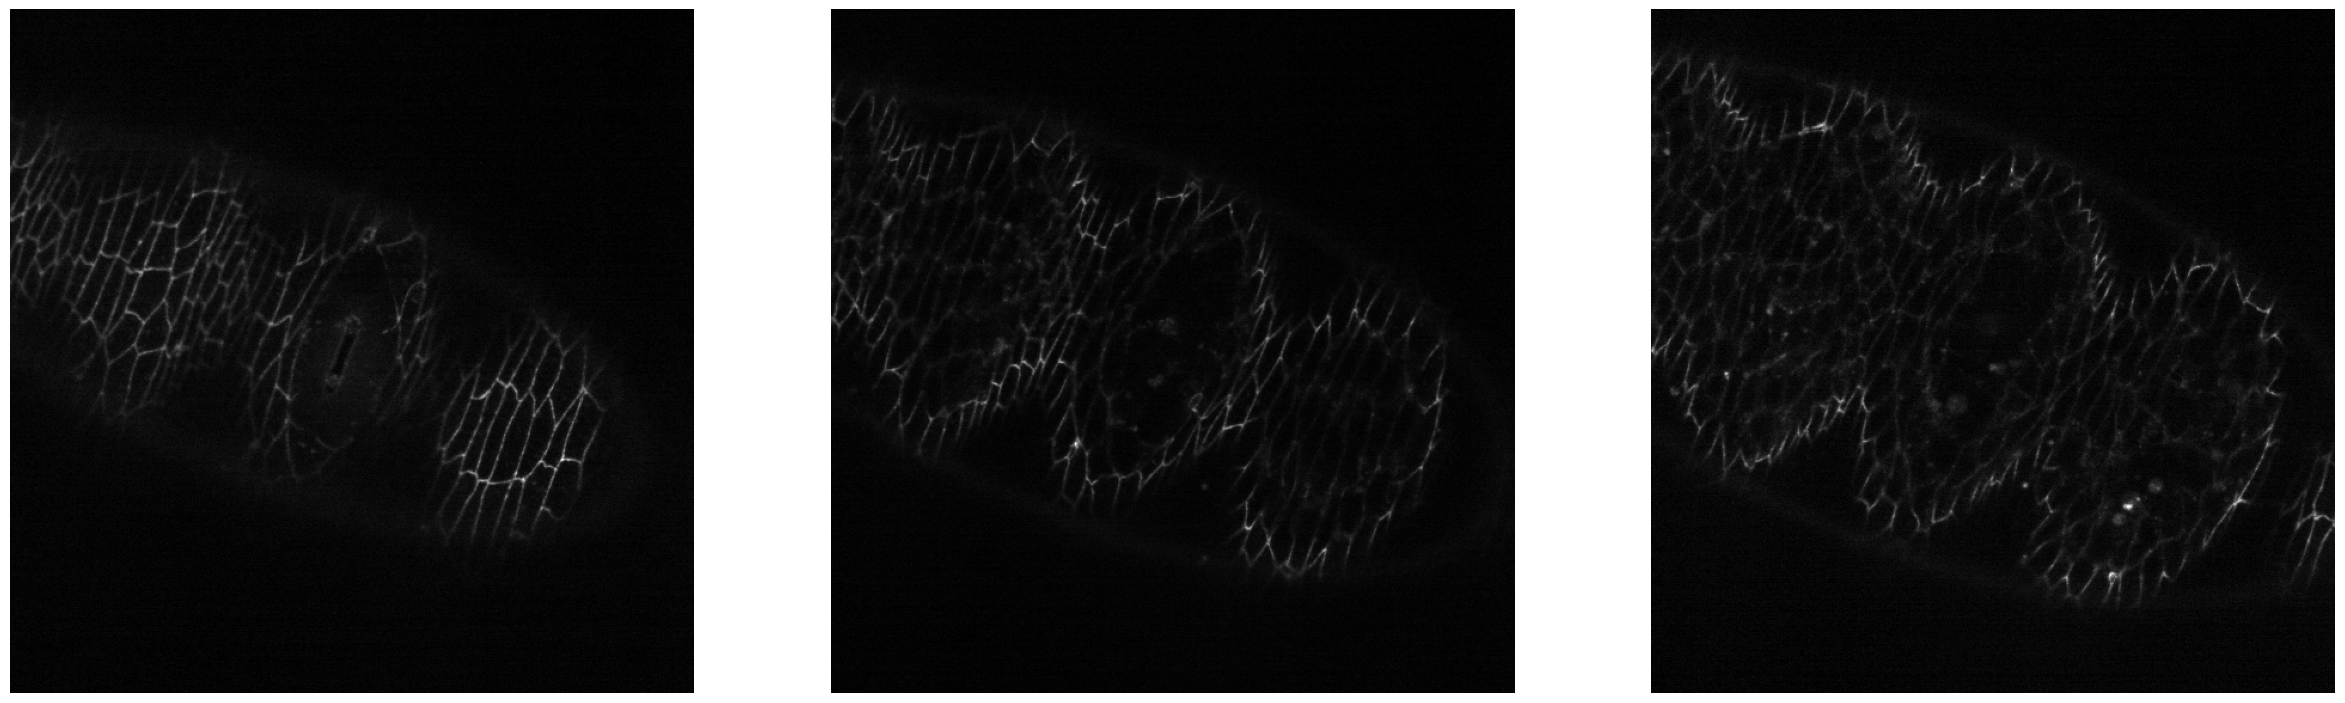

In [2]:
image_path = "Cadh3D_02_20230510.tif"
image = skimage.io.imread(image_path)
print(image.shape)

# (time, z-slice, H, W).


fig, ax = plt.subplots(1,3, figsize=(30, 20))
for i in range(3):
    ax[i].imshow(image[10, 3 + 2 * i],cmap="gray")
    ax[i].axis("off")

test_image = image[5, 3]/255


## Method of Simulation.
The fruit fly embryo is simulated as ellipsoidal volumes containing 3D voronoi tesselations.

Features of the embryo aside from the cells themselves:
* Towards the center of the embryo are areas without cells (cavities?).
* Agglomerates float around the embryo, which we are not interested in sesgmenting.
* Ellipse-shaped segments.

## Voronoi tesselation

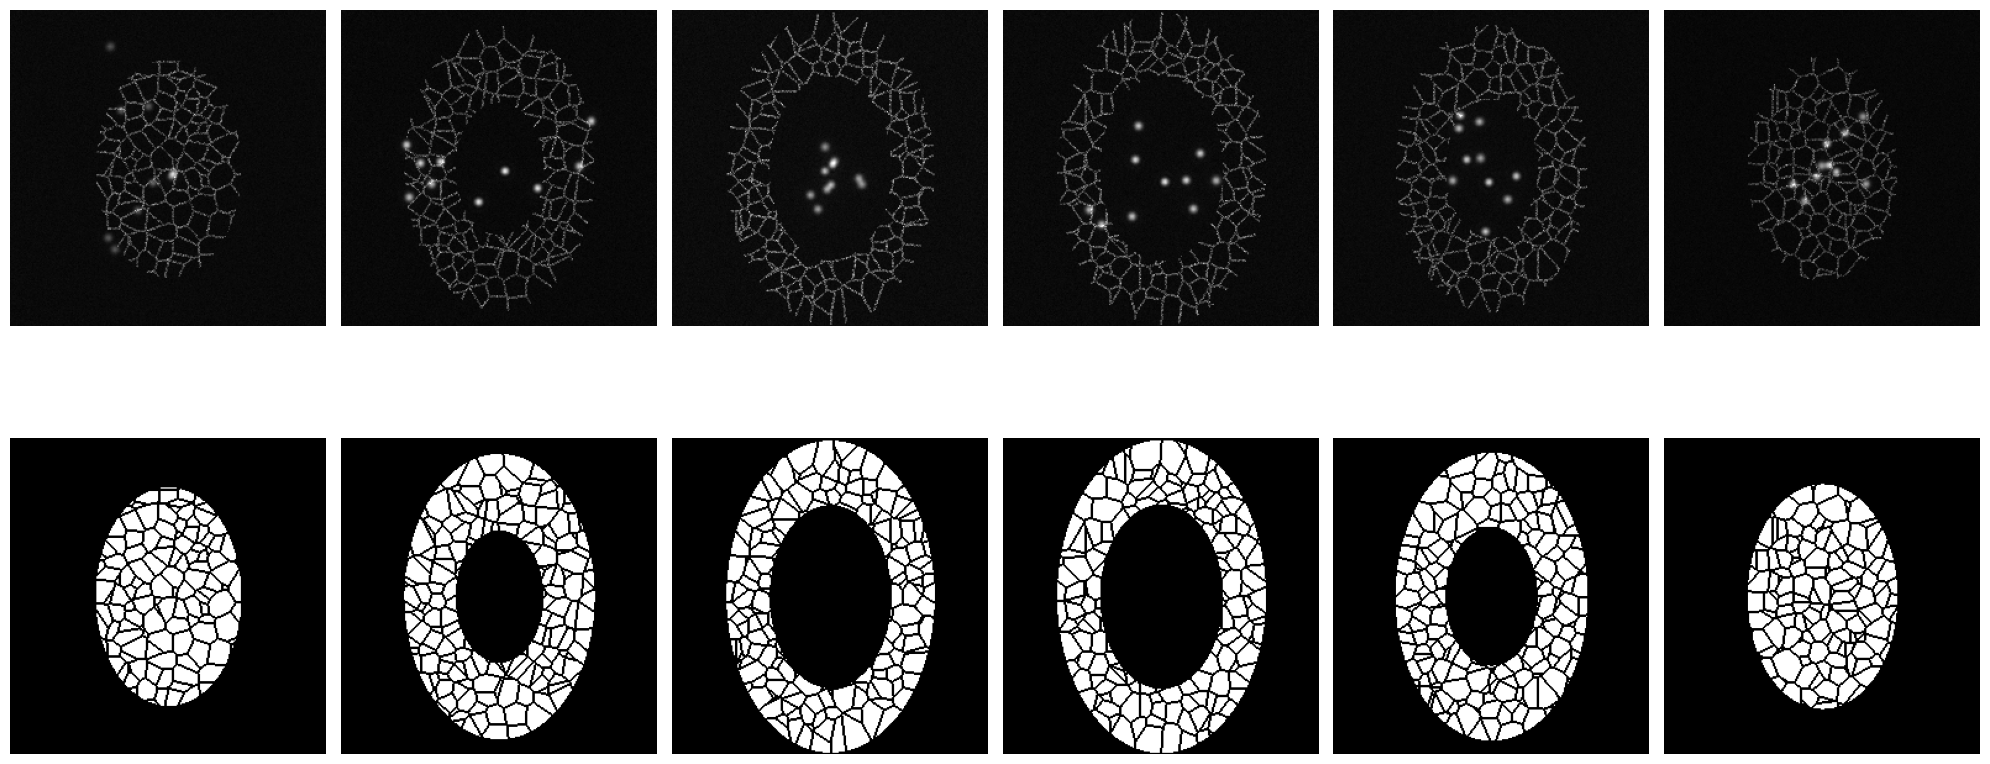

In [ ]:
def voronoi_tesselation_3D(SIZE=256, POINTS=1000, num_slices=8, inner_ratio=0.6):

    # Define the outer ellipsoid volume.
    center = np.array([SIZE/2, SIZE/2, SIZE/2])
    a = SIZE/2   
    b = SIZE/3    
    c = SIZE/5 

    # Define the inner ellipsoid.
    a_inner = a * inner_ratio
    b_inner = b * inner_ratio
    c_inner = c * inner_ratio
    
    # Inclusion function to check if point is inside volume.
    def inside_outer(pt):
        return (((pt[0] - center[0]) / a)**2 +
                ((pt[1] - center[1]) / b)**2 +
                ((pt[2] - center[2]) / c)**2) <= 1

    # Generate random points using discard method.
    seeds = []
    attempts = 0
    while len(seeds) < POINTS and attempts < POINTS * 10:
        pt = np.array([random.randint(20, SIZE-20) for _ in range(3)])
        if inside_outer(pt):
            seeds.append(pt)
        attempts += 1
    seeds = np.array(seeds)

    # The outer ellipsoid exists for z in [center_z-c, center_z+c]
    z_min = int(np.ceil(center[2] - c))
    z_max = int(np.floor(center[2] + c))
    z_slices = np.linspace(z_min, z_max, num_slices, dtype=int)

    # Remove first and last slices (looks better).
    z_slices = np.delete(z_slices, [0, -1])
    
    simulated_frames = []  
    ground_truth = []        
    optics = dt.Fluorescence(magnification=10, output_region=(0, 0, 256, 256),)
    
    for z in z_slices:

        # Create a grid for the current slice.
        X, Y = np.meshgrid(np.arange(SIZE), np.arange(SIZE), indexing='ij')
        
        # Compute outer ellipsoid cross-section mask.
        outer_remainder = 1 - ((z - center[2]) / c)**2
        outer_slice_mask = (
            ((X - center[0]) / a)**2 +
            ((Y - center[1]) / b)**2
        ) <= outer_remainder
        
        # Compute inner ellipsoid cross-section mask.
        inner_remainder = 1 - ((z - center[2]) / c_inner)**2
        inner_slice_mask = (
            ((X - center[0]) / a_inner)**2 +
            ((Y - center[1]) / b_inner)**2
        ) <= inner_remainder
        
        # Get volume enclosed by outer and inner ellipsoids.
        shell_mask = outer_slice_mask & (~inner_slice_mask)
        
        # Compute the Voronoi segmentation for this slice.
        diff_x = X[..., None] - seeds[:, 0]
        diff_y = Y[..., None] - seeds[:, 1]
        diff_z = z - seeds[:, 2]  
        distances = diff_x**2 + diff_y**2 + diff_z**2 
        labels = np.argmin(distances, axis=-1)

        # Cell boundaries.
        boundary = np.zeros_like(labels, dtype=np.uint8)
        boundary |= (labels != np.roll(labels, 1, axis=0))
        boundary |= (labels != np.roll(labels, -1, axis=0))
        boundary |= (labels != np.roll(labels, 1, axis=1))
        boundary |= (labels != np.roll(labels, -1, axis=1))
        boundary = boundary.astype(np.uint8) * 255

        # Only keep boundaries in the shell region.
        boundary[~shell_mask] = 0

        # Add agglomerates to the image by augmenting a sphere scatterer.
        # This method is much faster than resolving new scatterers.
        canvas = np.zeros((256, 256))
        agglomorate = optics(dt.Sphere(radius=0.5e-7, position=(128, 128)))
        
        agglomorate_count = 10
        for i in range(agglomorate_count):
            augmented_agglomorate = (
                agglomorate
                >> dt.Affine(translate= (np.random.standard_normal(2) * (10 + i)))
                >> dt.FlipLR()
                >> dt.FlipUD()
                >> dt.FlipDiagonal()
            ).resolve().squeeze()
            canvas += augmented_agglomorate

        canvas = (
            dt.Value(canvas)
            >> dt.NormalizeMinMax()
        ).resolve()
                  
        simulated_cells = (
            dt.Value(boundary)
            >> dt.Poisson(snr=30)
            >> dt.Gaussian(0, 10)
            >> dt.NormalizeMinMax()
        ).resolve() + canvas.squeeze()

        simulated_cells = (dt.Value(simulated_cells)>> dt.NormalizeMinMax()).resolve()
        simulated_frames.append(simulated_cells.astype(np.float32))
        
        # Construct GT from shell mask and boundary, 
        # GT will be the surface of the cells, not including their edges.        
        gt_boundary = (shell_mask.astype(np.uint8) * 255) - boundary
        gt_boundary = np.clip(gt_boundary, 0, 255)
        ground_truth.append(gt_boundary.astype(np.float32) / 255.0)
    
    return z_slices, simulated_frames, ground_truth

# Run the simulation.
z_slices, observed_slices, gt_slices = voronoi_tesselation_3D()

fig, axs = plt.subplots(2, len(z_slices), figsize=(20, 10))
for i, z in enumerate(z_slices):
    axs[0, i].imshow(observed_slices[i], cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(gt_slices[i], cmap="gray")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

# Temporal information, voronoi random walk, 3D.

In [10]:
class Voronoi_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_generator, device="auto", dataset_size=1):
        self.device=device
        self.generate_data = data_generator
        dataset = []
        for i in range(dataset_size):

            # One call of generate_data returns multiple images and GT's.
            _, images, gts = self.generate_data()
            for image, gt in zip(images, gts):
                
                dataset.append([torch.tensor(image).unsqueeze(0), torch.tensor(gt).unsqueeze(0)]) 
    
        self.dataset = dataset

        self.dataset_size = dataset_size

    def __len__(self):
        return self.dataset_size 
    
    def __getitem__(self, idx):
        return random.choice(self.dataset)
voronoi_dataset = Voronoi_Dataset(voronoi_tesselation_3D, dataset_size=1)

### Fetch item from dataset.

Text(0.5, 1.0, 'Ground Truth Mask')

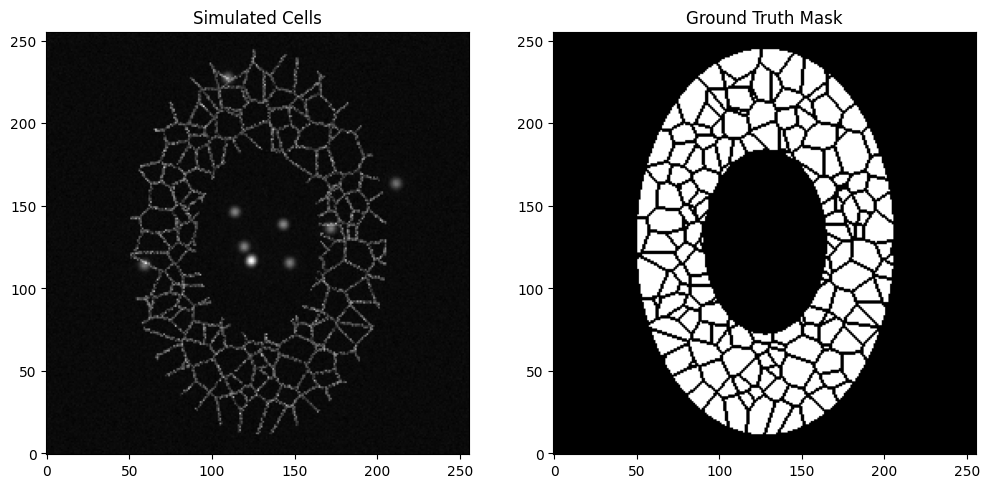

In [22]:
sample = voronoi_dataset.__getitem__(0)
simulated_image = sample[0]
mask = sample[1]

fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(simulated_image.squeeze(), cmap="gray", origin="lower")
ax[0].set_title("Simulated Cells")
ax[1].imshow(mask.squeeze(), cmap="gray", origin="lower")
ax[1].set_title("Ground Truth Mask")


In [23]:
model = dl.UNet2d(
    in_channels=1,
    channels=[16, 32, 64, 128],
    out_channels=1,
)
unet_reg = dl.Regressor(
    model=model,
    loss=torch.nn.MSELoss(),
    optimizer=dl.Adam(lr=1e-3),
).build()

train_loader = torch.utils.data.DataLoader(
    voronoi_dataset,
    batch_size=8,
    shuffle=True,
)

LOAD_MODEL = False

if LOAD_MODEL:
    unet_reg.load_state_dict(torch.load("unet_weights_150pts.pth", weights_only=True))
    
else:
    unet_trainer = dl.Trainer(max_epochs=200, accelerator="auto")
    unet_trainer.fit(unet_reg, train_loader)
    torch.save(unet_reg.state_dict(), "unet_weights_150pts.pth")
    unet_trainer.history.plot()

c:\Users\xlecal\Documents\.venv\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ MSELoss          │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ UNet2d           │  525 K │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 525 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 525 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 50                                                                                          
Modules in eval mode: 0

Output()

c:\Users\xlecal\Documents\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\xlecal\Documents\.venv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


NameError: name 'exit' is not defined

tensor(1.)


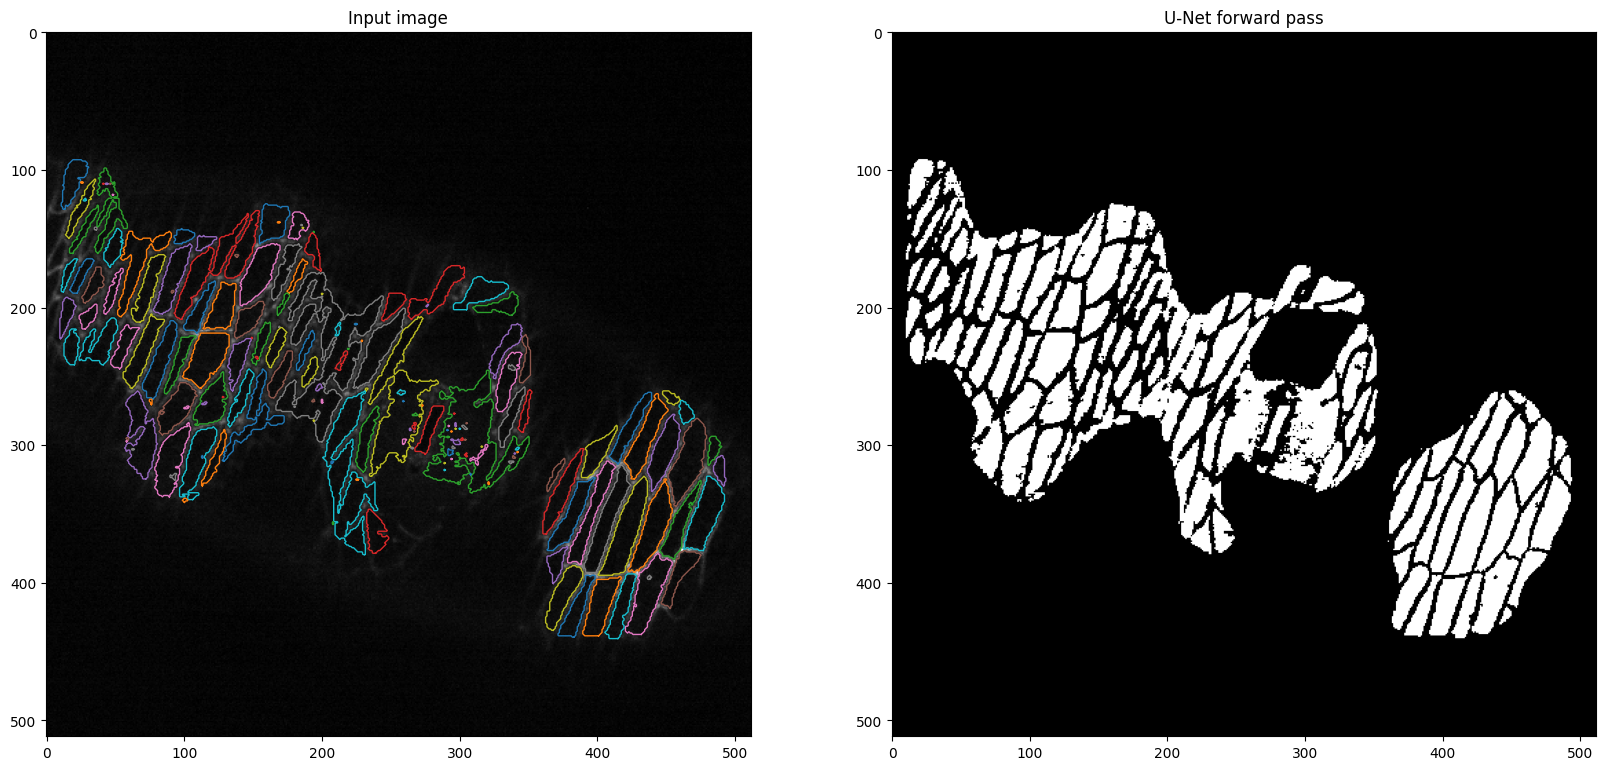

In [8]:
from skimage.measure import label, regionprops, find_contours


test_tensor = torch.Tensor(test_image[0:512, 0:512]/np.max(test_image)).unsqueeze(0).unsqueeze(0)
# Threshhold if needed.
print(test_tensor.max())
forward = (unet_reg(test_tensor)).detach().numpy().squeeze(0).squeeze(0)
forward = forward > .55
labels = label(forward)
props = regionprops(labels, forward)
properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean']

_list = []
for i in props:
    _list.append(i.area)
_list = np.array(_list)

props = np.array([prop for prop in props if prop.area >= 70 and prop.area <=  20000])

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(test_tensor.detach().numpy().squeeze(0).squeeze(0), cmap="gray")
ax[0].set_title("Input image")

ax[1].imshow(forward, cmap="gray")
ax[1].set_title("U-Net forward pass")

for index in range(len(props)):
    label_i = props[index].label
    contours = find_contours(labels == label_i, 0.5)
    for contour in contours:
        ax[0].plot(contour[:, 1], contour[:, 0], linewidth=1, label=f'Label {label_i}')
        centroid = props[index].centroid

## Data background.

* Drosophilia embryo (fruit fly), stage 15-16 after dorsal closure before muscle development.
* Labeled membranes with fluorescent Cadherin tomato protein.🍅
* 1 frame = 1 minute, videos are usually 40-90 minutes.

 